# TEM Image Processing Pipeline

In this notebook we implement an image processing pipeline to extract information from transmission electron microscopy images of barium titanate nanoparticles in a low density polyethylene _matrix_. Information gained from this process includes the:
- number of particles, $N_p$
- number of agglomerates, $N_a$
- size of particles (longest and shortest chord lengths)
- locations of particles (x,y)
- number of particles per agglomerate, $n$
- factor of agglomeration

where factor of agglomeration is given by:
$$F_a = \frac{N_a \cdot n}{N_p}$$

## Import necessary libraries

In [1]:
import cv2 as cv                   # OpenCV for image processing
import matplotlib.pyplot as plt    # Matplotlib for visualizing
import numpy as np                 # NumPy for quick maths
from collections import Counter
# import seaborn as sb

## Define nm per pixel

In TES-II-36a.tif there are 113 pixels per 100 nm

In [33]:
pixel_per_nm = 113 / 100
nm_per_pixel = 1 / pixel_per_nm
print(nm_per_pixel)

0.8849557522123894


## Load input data and apply grayscale

We don't need to process input image with 3 color channels as TEM images tend to be grayscale. Now each pixel will be 8 bits ranging from 0 (light) to 255 (dark).

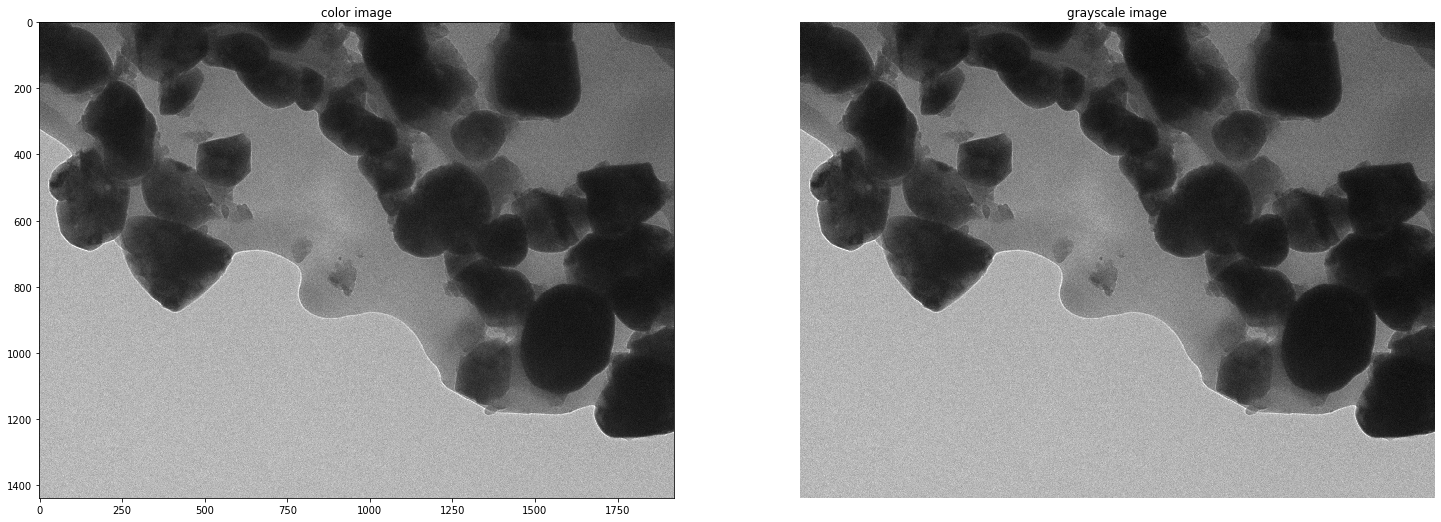

In [3]:
# display images inline in notebook, comment can't be on same line (glitch)
%matplotlib inline 

IMAGE_NAME = "TES-II-36a-cropped.tif"
# IMAGE_NAME = "500_scale_BM_20V_200_10=200_20_BM_100 no 10.png"
# IMAGE_NAME = "easy_particles.png" 

# color_image = cv.imread(IMAGE_NAME) # read a color image

# color_image = cv.cvtColor(color_image, cv.COLOR_BGR2RGB)                # convert from BGR to RGB
# not_color_image = cv.cvtColor(color_image, cv.COLOR_RGB2GRAY)           # convert color to grayscale
# gray_image = cv.imread(IMAGE_NAME, cv.IMREAD_GRAYSCALE)

color_image = cv.imread(IMAGE_NAME)
gray_image = cv.cvtColor(color_image, cv.COLOR_BGR2GRAY)

# plot input and grayscale input
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(25,25))
plt.axis("off")
ax0.imshow(color_image)
ax0.set_title("color image");
# ax1.imshow(gray_image)
ax1.imshow(gray_image, cmap = plt.cm.gray) 
ax1.set_title("grayscale image");

In [4]:
# reshape images to be a ndarray of pixels
# color_pixels = color_image.reshape((color_image.shape[0] * color_image.shape[1], 3))
# gray_pixels = color_image.reshape((gray_image.shape[0] * gray_image.shape[1], 3))

## Gaussian blur 

TEM images have noise (looks like a fine grain filter accross image). To smooth out these grains we apply a gaussian blur.

TODO: explain kernel matrix

Text(0.5, 1.0, 'kernel matrix size 5 by 5')

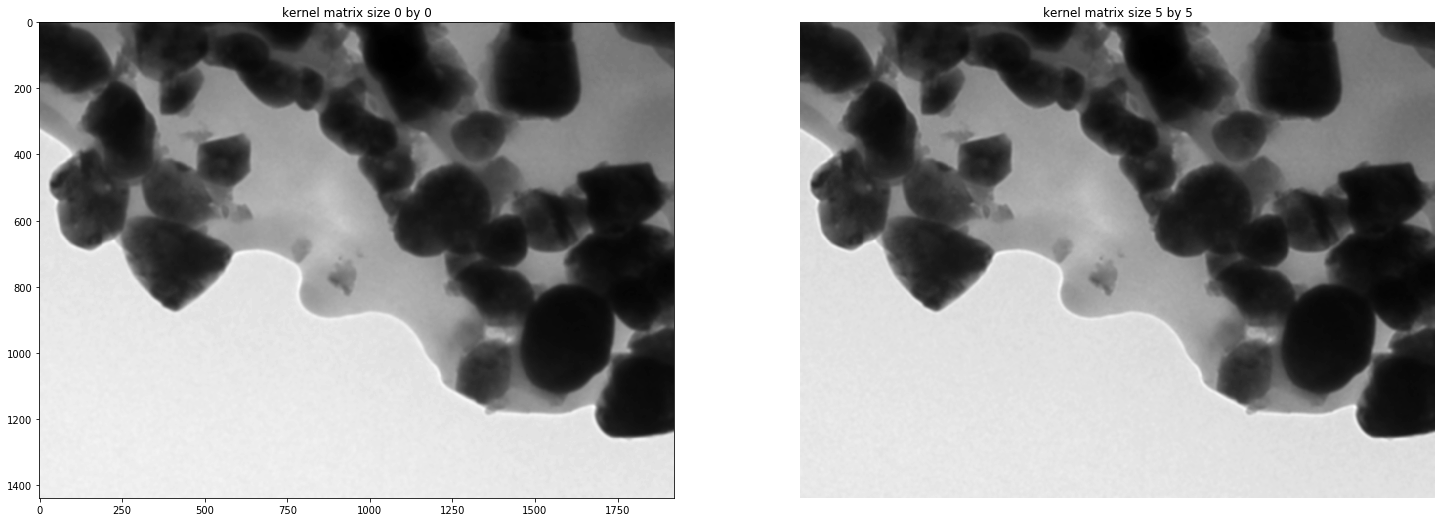

In [5]:
# apply gaussian blur
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(25,25))
plt.axis("off")
blur_1 = cv.GaussianBlur(gray_image, (0,0) ,cv.BORDER_DEFAULT) 
ax0.imshow(blur_1, cmap = plt.cm.gray) 
ax0.set_title("kernel matrix size 0 by 0")
blur_2 = cv.GaussianBlur(gray_image, (15,15) ,cv.BORDER_DEFAULT) # why only (0,0), (1,1), (5,5) work?
ax1.imshow(blur_2, cmap = plt.cm.gray)
ax1.set_title("kernel matrix size 5 by 5")

## Binary Threshold 

Convert grayscale pixels to only take on values of 0 (light) or 1 (dark). This helps us reduce image size for faster processing but also results in a significant loss of information from the original image.

TODO: explain OTSU's method

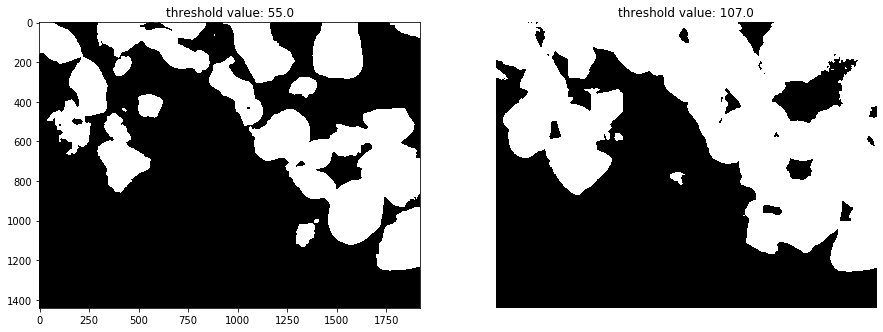

In [6]:
# auto binary threshold color image
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))
plt.axis("off")
ret_1, thresh_1 = cv.threshold(blur_1, 55, 255, cv.THRESH_BINARY_INV)
ax0.imshow(thresh_1, cmap = plt.cm.gray)
ax0.set_title("threshold value: " + str(ret_1));

# auto binary threshold grayscale image with Otsu's method
ret_2, thresh_2 = cv.threshold(blur_1, 120, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
ax1.imshow(thresh_2, cmap = plt.cm.gray)
ax1.set_title("threshold value: " + str(ret_2));

## Obtaining sure background and sure foreground

Text(0.5, 1.0, 'dist transform')

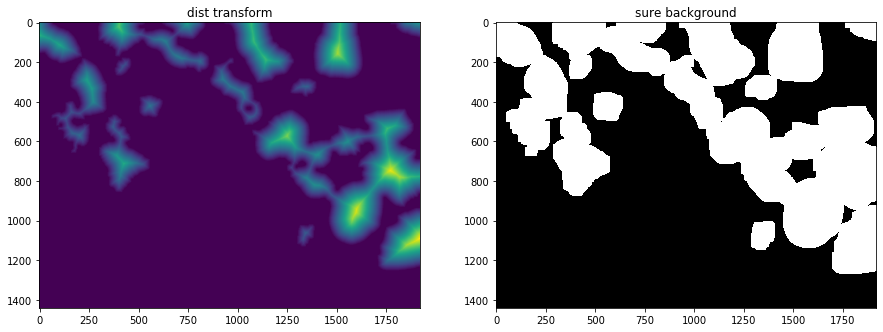

In [7]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))

# noise removal
kernel = np.ones((10,10),np.uint8)
opening = cv.morphologyEx(thresh_1,cv.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)
ax1.imshow(sure_bg, cmap = plt.cm.gray)
ax1.set_title("sure background")

# Finding distance transform
# Lighter spots mean further away from contours
dist_transform = cv.distanceTransform(opening,cv.DIST_L2, 5)

ax0.imshow(dist_transform)
# ax0.imshow(unknown, cmap = plt.cm.gray)
ax0.set_title("dist transform")

## Threshold distance transform by the average value of intesities (TOOD: unsure of where to use)

Get average value of intensities

In [8]:
# get sum of inensity values in distance transform
dist_sum = np.sum(dist_transform)
# get count of nonzero intensities in distance transform
nonzero_counter = Counter()
for row in dist_transform:
    nonzero_counter += Counter(row)
nonzero_count = len(dist_transform)*len(dist_transform[0]) - nonzero_counter[0.0]

print(dist_sum, nonzero_count)
average_value = dist_sum / nonzero_count

# dist_norm = np.zeros((len(dist_transform), len(dist_transform[0])))

# for row in range(len(dist_transform)):
#     for col in range(len(dist_transform[0])):
#         if dist_transform[row][col] <= average_half and dist_transform[row][col] >= 2:
#             dist_norm[row][col] += average_half
#         else:
#             dist_norm[row][col] -= average_value
            
# ax1.imshow(dist_norm, cmap=plt.cm.gray)
# ax1.set_title("normalized distance transform")

31324508.0 817459


Threshold distance transform at average value

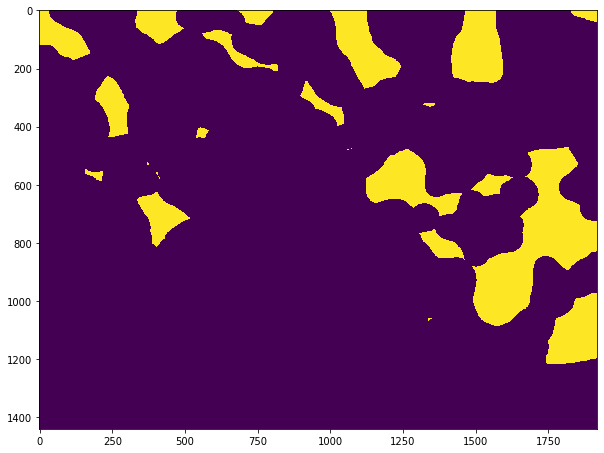

In [9]:
fig, ax0 = plt.subplots(1, 1, figsize=(10,10))
ret, dist_average = cv.threshold(dist_transform, average_value, 255, 0)
ax0.imshow(dist_average)

## 1. Contour Agglomerates

Text(0.5, 1.0, 'sure foreground')

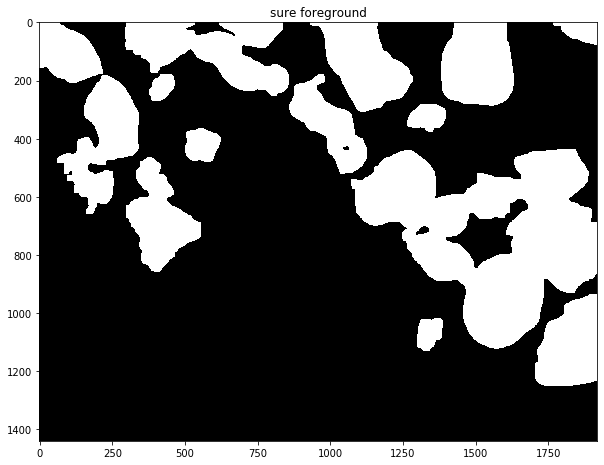

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

ret, sure_fg = cv.threshold(dist_transform, 0.01*dist_transform.max(), 255, 0)
axs.imshow(sure_fg, cmap = plt.cm.gray)
axs.set_title("sure foreground")

Text(0.5, 1.0, 'unknown = background - foreground')

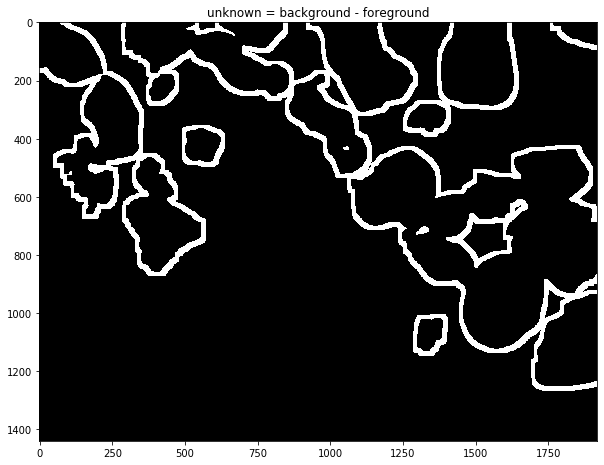

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg, sure_fg)

plt.imshow(unknown, cmap = plt.cm.gray)
axs.set_title("unknown = background - foreground")

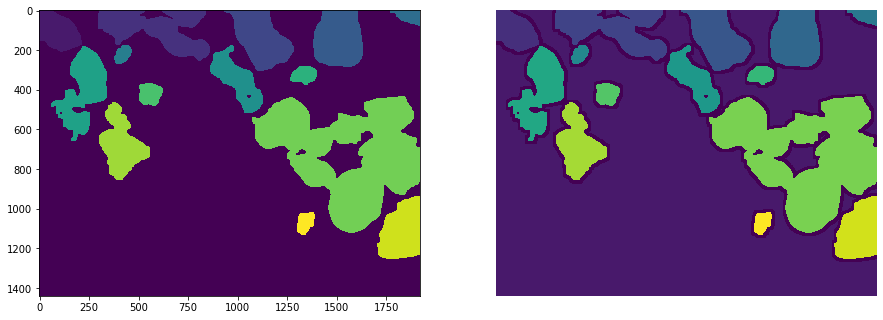

In [12]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))
plt.axis("off")

# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
ax0.imshow(markers)

# If unknown's pixel is 255 (white), set corresponding pixel in markers to 0
markers[unknown==255] = 0
ax1.imshow(markers)

In [13]:
# copy input image
color_copy_1 = color_image.copy()

# TODO matrix multiplication optimization

for row in range(len(color_copy_1)):
    for col in range(len(color_copy_1[0])):
        if unknown[row][col] == 255:
            color_copy_1[row][col] = [255,0,0]

we set all boundary pixels to -1, then loop through all of them to make them red

then overlay red pixels on original image

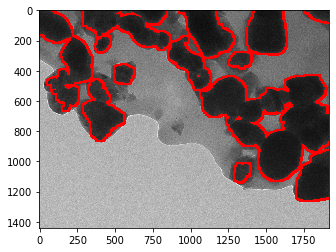

In [14]:
plt.imshow(color_copy_1)

## 2. Contour particles 

Threshold distance transform with a higher value to get particle centers for watershed algorithm

Text(0.5, 1.0, 'sure foreground')

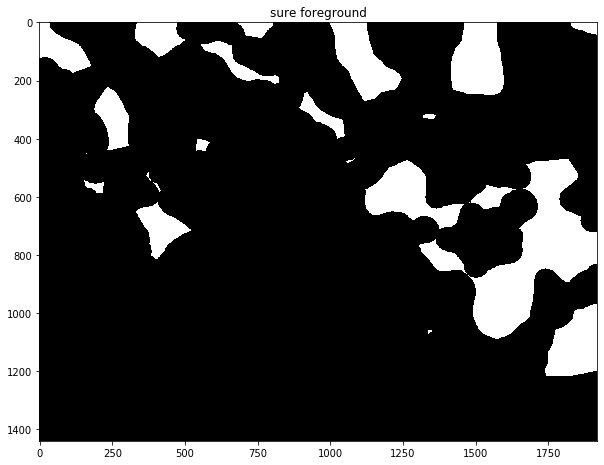

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

ret_2, sure_fg_2 = cv.threshold(dist_transform, 0.25*dist_transform.max(), 255, 0)
axs.imshow(sure_fg_2, cmap = plt.cm.gray)
axs.set_title("sure foreground")

In [16]:
# Finding unknown region
sure_fg_2 = np.uint8(sure_fg_2)
unknown_2 = cv.subtract(sure_bg, sure_fg_2)

Text(0.5, 1.0, 'markers_2')

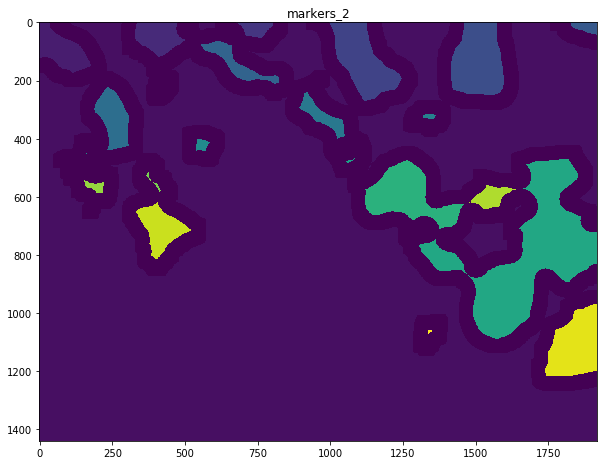

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

# Marker labelling
ret_2, markers_2 = cv.connectedComponents(sure_fg_2)
# Add one to all labels so that sure background is not 0, but 1
markers_2 = markers_2+1
# Now, mark the region of unknown with zero
markers_2[unknown_2==255] = 0

axs.imshow(markers_2)
axs.set_title("markers_2")

Run watershed algorithm from particle centers

16
15


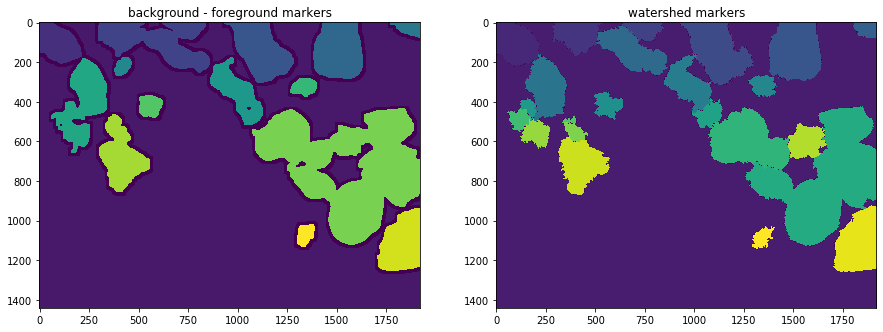

In [18]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))

# copy input image
color_copy_2 = color_image.copy()

watershed_markers = cv.watershed(color_copy_2, markers_2)
color_copy_2[markers_2 == -1] = [255,0,0]

# apply Gaussian blur to markers to smooth out
# blur_watershed_markers = cv.blur(watershed_markers, (0,0) ,cv.BORDER_DEFAULT) 

ax0.imshow(markers)
ax0.set_title("background - foreground markers")
ax1.imshow(watershed_markers)
ax1.set_title("watershed markers")
# ax2.imshow(blur_watershed_markers)
# ax2.set_title("blurred watershed markers")

print(watershed_markers[600][1300])
print(watershed_markers[800][1750])

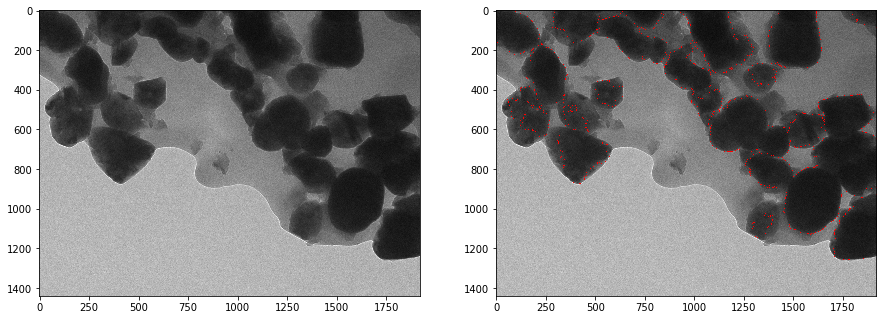

In [19]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))

ax0.imshow(color_image)
ax1.imshow(color_copy_2)

## 3. Contours derived from Watershed algorithm

Markers pt.2 except this time they're derived from watershed instead of background - foreground

First create contour pixels and get their colors

In [20]:
# pixels are appended as (col, row) in order to feed to cv.lines() later on

# copy input image
color_copy_3 = color_image.copy()

# dictionary mapping colors to their pixels
contour_colors = {}

contour_size = 0
# loop through pixels in watershed markers
for row in range(1, len(watershed_markers) - 1):
    for col in range(1, len(watershed_markers[0]) - 1):
        # if pixel not in background
        if watershed_markers[row][col] != 1:
            # get current pixel and its neighbours 
            current = watershed_markers[row][col]
            up = watershed_markers[row-1][col]
            down = watershed_markers[row+1][col]
            left = watershed_markers[row][col-1]
            right = watershed_markers[row][col+1]
            # if not surrounded by uniform pixels
            if ((up != current) or (down != current) or (left != current) or (right != current)):
                # if the right pixel is different
                if (right != current):
                    # add current pixel to dictionary
                    if current not in contour_colors:
                        contour_colors[current] = [(col, row)]
                    else:
                        contour_colors[current] += [(col,row)]
                    
                    # if the right pixel is not in background, add it to the dictionary
                    if (right != 1):
                        if right not in contour_colors:
                            contour_colors[right] = [(col+1, row)]
                        else:
                            contour_colors[right] += [(col+1,row)]
                        color_copy_3[row][col+1] = [255, 0, 0]
                        contour_size += 1
                        
                    color_copy_3[row][col] = [255, 0, 0]
                    contour_size += 1
                    
                # if the down pixel is different
                elif (down != current):
                    # add current pixel to dictionary
                    if current not in contour_colors:
                        contour_colors[current] = [(col, row)]
                    else:
                        contour_colors[current] += [(col,row)]
                    
                    # if the down pixel is not in background, add it to the dictionary
                    if (down != 1):
                        if down not in contour_colors:
                            contour_colors[down] = [(col, row+1)]
                        else:
                            contour_colors[down] += [(col,row+1)]
                        color_copy_3[row+1][col] = [255, 0, 0]
                        contour_size += 1
                        
                    color_copy_3[row][col] = [255, 0, 0]
                    contour_size += 1
                
                # if the up or left pixel is different than the current pixel and is not a border pixel
                elif (((up != 255) and (up != current)) or ((left != 255) and (left != current))):
                    # add current pixel to dictionary
                    if current not in contour_colors:
                        contour_colors[current] = [(col, row)]
                    else:
                        contour_colors[current] += [(col,row)]
                        
                    color_copy_3[row][col] = [255, 0, 0]                    
                    contour_size += 1

print(contour_size)

60246


In [21]:
# remove -1 key from contour_colors because it represents bad contours drawn by cv.watershed()
del contour_colors[-1]

Then use list of pixels grouped by color to get chord lengths

In [22]:
# input pixels as tuples
def pixel_distance(pixel1, pixel2):
    return np.power(np.power(pixel1[0] - pixel2[0], 2) + np.power(pixel1[1] - pixel2[1], 2), 0.5)

In [23]:
# currently 1411 pixels per 100nm = 14.11 pixels per 1nm = 1 pixel per 
def pixels_to_nm(pixel_distance):
    # TODO: implement
    pass
    

In [24]:
# dictionary to map particles to their extracted information
particles = {}

longest_pairs = []
# loop through all colors
for color in contour_colors:
    # loop through all pixels in a color
    color_pixels = contour_colors[color]
    max = 0
    for i in range(len(color_pixels)):
        for j in range(len(color_pixels[i:])):
            distance = pixel_distance(color_pixels[i], color_pixels[j])
            if distance > max:
                max = distance
                longest_pair = [color, color_pixels[i], color_pixels[j]]
    # keep track of longest chord length pair for each color 
    longest_pairs += [longest_pair]
    # add to particles dictionary, accounting for nm per pixel
    particles[color] = [("a", color, max*nm_per_pixel)]
            
print(longest_pairs)

[[2, (1, 1), (214, 183)], [3, (539, 1), (287, 99)], [4, (635, 1), (847, 31)], [5, (926, 7), (1299, 220)], [6, (1616, 1), (1390, 271)], [7, (1793, 1), (1918, 88)], [8, (514, 50), (864, 231)], [9, (226, 160), (206, 502)], [10, (1009, 161), (995, 457)], [11, (1272, 293), (1409, 352)], [12, (495, 370), (637, 434)], [14, (1128, 389), (1024, 530)], [13, (157, 384), (181, 500)], [15, (1847, 425), (1484, 1102)], [16, (1084, 514), (1477, 699)], [17, (55, 452), (164, 518)], [18, (400, 479), (335, 506)], [21, (167, 489), (251, 631)], [20, (337, 508), (455, 595)], [19, (379, 510), (378, 512)], [22, (1644, 530), (1479, 673)], [23, (369, 574), (426, 872)], [24, (1918, 928), (1718, 1251)], [25, (1403, 1034), (1291, 1130)]]


draw lines between longest chord lengths

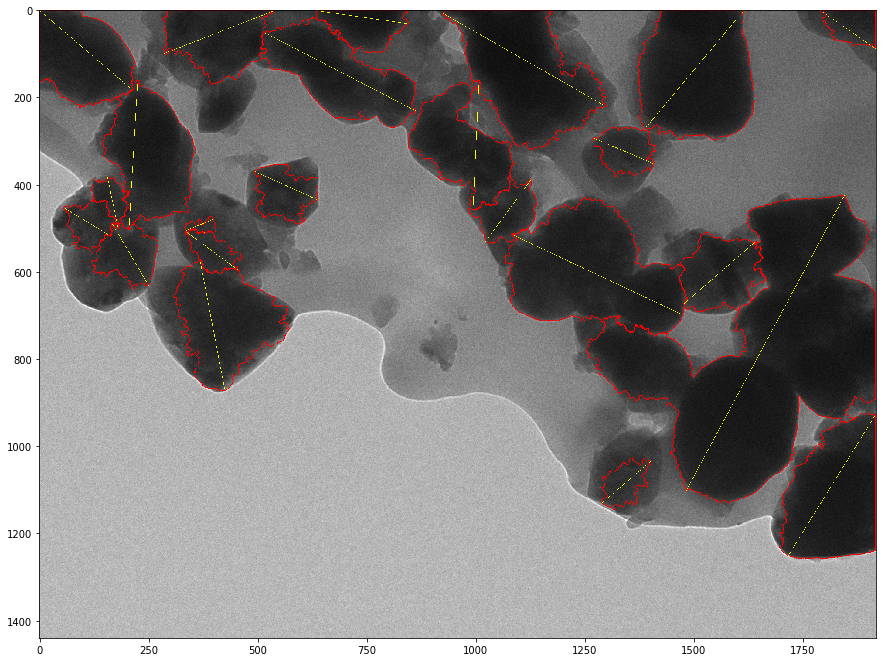

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(15,15))

for longest_pair in longest_pairs:
    cv.line(color_copy_3, longest_pair[1], longest_pair[2], [255,255,0])

axs.imshow(color_copy_3)

plt.savefig("longest_chords.png", dpi=500)

Visualizing contour for single color (14)

In [26]:
# fig, axs = plt.subplots(1, 1, figsize=(15,15))
# # copy input image
# individual_markers_outline = color_image.copy()
# current_color = 14
# current_pixels = contour_colors[current_color]
# for row in range(len(individual_markers_outline)):
#     for col in range(len(individual_markers_outline[0])):
#         if (col, row) in current_pixels:
#             individual_markers_outline[row][col] = [255,0,0]
# axs.imshow(individual_markers_outline)

In [27]:
short_pairs = []
scores = []

for pair in longest_pairs:
    current_pixels = contour_colors[pair[0]]
    short_pair = []
    current_score = []
    x1 = pair[1][0]
    y1 = pair[1][1]
    x2 = pair[2][0]
    y2 = pair[2][1]
    slope = (y2-y1)/(x2-x1)
    orthogonal_slope = -1/slope
    if x1 > x2:
        mid_x = x2 + int((x1-x2)/2)
    else:
        mid_x = x1 + int((x2-x1)/2)
    if y1 > y2:
        mid_y = y2 + int((y1-y2)/2)
    else:
        mid_y = y1 + int((y2-y1)/2)
        
    # # add centerpoints particles dictionary, accounting for nm per pixel
    particles[pair[0]] += [("x", pair[0], mid_x*nm_per_pixel)]
    particles[pair[0]] += [("y", pair[0], mid_y*nm_per_pixel)]
    particles[pair[0]] += [("z", pair[0], 100)]

    for pixel in current_pixels:
        dx = pixel[0] - mid_x
        dy = pixel[1] - mid_y
        if dx != 0:
            comp_slope = dy/dx
            score = np.abs(1 - comp_slope / orthogonal_slope)
            if (score < 0.5):
                if pixel not in short_pair:
                    short_pair += [pixel]
                    current_score += [score]
    short_pairs += [short_pair]
    scores += [current_score]

In [29]:
# store min pixel pairs to visualize lines
min_pixel_pairs = []
    
# process pairs to keep ones with min score
for i in range(len(short_pairs)):
    if len(short_pairs[i]) >= 2:
    #     first find pixel with overall minimum
        min_index_1 = np.argmin(scores[i])
        min_pixel_1 = short_pairs[i][min_index_1]
        
        # now loop through rest of pixels to find far away pixel with low score
        min_distance = 100 # TODO: generalize for different particle sizes
        for j in range(len(short_pairs[i])):
            distance = pixel_distance(min_pixel_1, short_pairs[i][j])
            if distance > min_distance:
                min_pixel_2 = short_pairs[i][j]
                
                # store pixels for cv.line() later
                min_pixel_pairs += [[min_pixel_1, min_pixel_2]]
                
                # longest_pairs[i][0] is current color
                # add short distance to particles dictionary, accounting for nm per pixel
                particles[longest_pairs[i][0]] += [("b", distance*nm_per_pixel)] 
                break

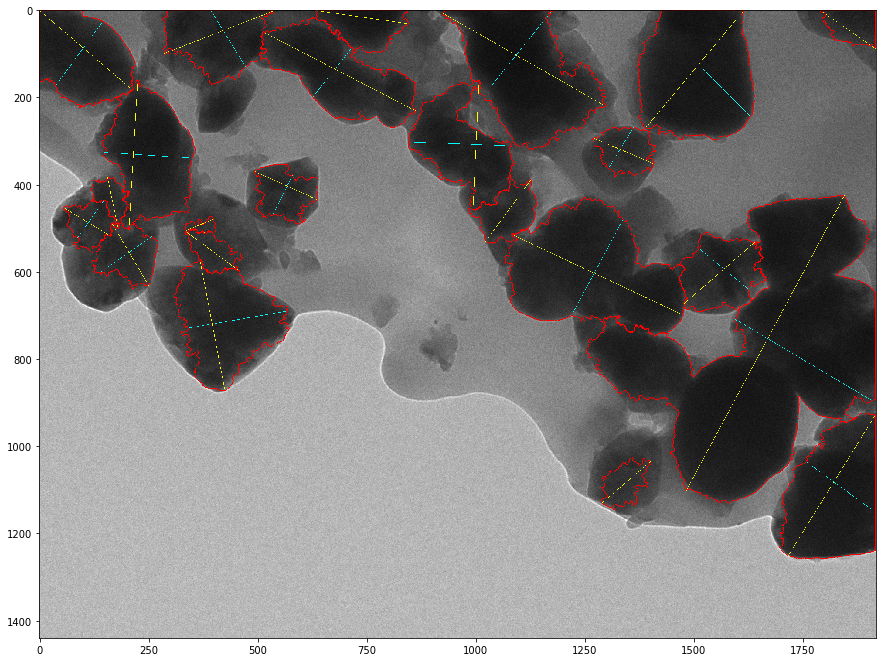

In [30]:
fig, axs = plt.subplots(1, 1, figsize=(15,15))

# copy input image
midpoint_test = color_image.copy()

for short_pair in min_pixel_pairs:
#     print(short_pair[1])
    cv.line(color_copy_3, short_pair[0], short_pair[1], [0,255,255])

axs.imshow(color_copy_3)

plt.savefig("perpendicular_chords_0.5.png", dpi=500)

Average long and short chord lengths to get z-axis chord length
TODO: make more accurate

In [31]:
# loop through particles dictionary 
for particle in particles:
    particle_data = particles[particle]
    if len(particle_data) == 5:
        # c = a + b / 2
        pixel_c = (particle_data[0][-1] + particle_data[-1][-1]) / 2
        particles[particle] += [("c", particle, pixel_c)]
        
for particle in particles:
    print(particles[particle])

[('a', 2, 247.93453292766495), ('x', 2, 94.69026548672566), ('y', 2, 81.41592920353983), ('z', 2, 100), ('b', 161.42378881656913), ('c', 2, 204.67916087211705)]
[('a', 3, 239.27868214300136), ('x', 3, 365.4867256637168), ('y', 3, 44.24778761061947), ('z', 3, 100), ('b', 133.11158368576392), ('c', 3, 186.19513291438264)]
[('a', 4, 189.47975235520101), ('x', 4, 655.7522123893806), ('y', 4, 14.15929203539823), ('z', 4, 100)]
[('a', 5, 380.11708300088094), ('x', 5, 984.070796460177), ('y', 5, 100.0), ('z', 5, 100), ('b', 220.30244270556983), ('c', 5, 300.20976285322536)]
[('a', 6, 311.5949184726056), ('x', 6, 1330.0884955752213), ('y', 6, 120.35398230088497), ('z', 6, 100), ('b', 269.7025159290168), ('c', 6, 290.64871720081123)]
[('a', 7, 134.77501316702524), ('x', 7, 1641.5929203539824), ('y', 7, 38.93805309734513), ('z', 7, 100)]
[('a', 8, 348.7006412487636), ('x', 8, 609.7345132743363), ('y', 8, 123.89380530973452), ('z', 8, 100), ('b', 127.2922027423669), ('c', 8, 237.99642199556524)]


# Save output as .txt for COMSOL

In [32]:
filename = "COMSOL_input.txt"

# test output
# output = [("a", 1000, 78), ("x", 1000, 70), ("y", 1000, 500), ("z", 1000, 75), ("b", 1000, 169), ("c", 1000, 103)]

# save output as e.g. a3000 100[nm] where a/b/c is chord length direction, 3000 is particle number, 100[nm] is 
output_file = open(filename, "w")
for particle in particles:
    particle_data = particles[particle]
#     print(particle_data[0][2])
    if len(particle_data) == 6: # TODO: figure out why some is < 6
        output_file.writelines(particle_data[0][0] + str(particle) + " " + str(particle_data[0][2]) + "[nm]" + "\n")  # a
        output_file.writelines(particle_data[4][0] + str(particle) + " " + str(particle_data[4][-1]) + "[nm]" + "\n") # b
        output_file.writelines(particle_data[5][0] + str(particle) + " " + str(particle_data[5][2]) + "[nm]" + "\n")  # c
        output_file.writelines(particle_data[1][0] + str(particle) + " " + str(particle_data[1][2]) + "[nm]" + "\n")  # x
        output_file.writelines(particle_data[2][0] + str(particle) + " " + str(particle_data[2][2]) + "[nm]" + "\n")  # y
        output_file.writelines(particle_data[3][0] + str(particle) + " " + str(particle_data[3][2]) + "[nm]" + "\n")  # z
output_file.close()